## 1. Importar librerías y cargar datos
Importamos las librerías necesarias y cargamos el dataset.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.api import OLS, add_constant

# Cargar el archivo CSV (ajusta la ruta si es necesario)
ruta = 'millas-por-galon.csv'
df = pd.read_csv(ruta)
df.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,mpg,car name
0,discrete,continuous,continuous,continuous,continuous,discrete,discrete,continuous,string
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,class,meta
2,8,307.0,130.0,3504.0,12.0,70,1,18.0,chevrolet chevelle malibu
3,8,350.0,165.0,3693.0,11.5,70,1,15.0,buick skylark 320
4,8,318.0,150.0,3436.0,11.0,70,1,18.0,plymouth satellite


: 

## 2. Análisis exploratorio de los datos
Descripción de variables, visualización y análisis de linealidad.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cylinders     399 non-null    object
 1   displacement  399 non-null    object
 2   horsepower    393 non-null    object
 3   weight        399 non-null    object
 4   acceleration  399 non-null    object
 5   model year    399 non-null    object
 6   origin        399 non-null    object
 7   mpg           400 non-null    object
 8   car name      400 non-null    object
dtypes: object(9)
memory usage: 28.3+ KB
None
       cylinders displacement horsepower  weight acceleration model year  \
count        399          399        393     399          399        399   
unique         6           83         94     352           96         14   
top            4         97.0      150.0  1985.0         14.5         73   
freq         204           21         22       4           23         40   

       

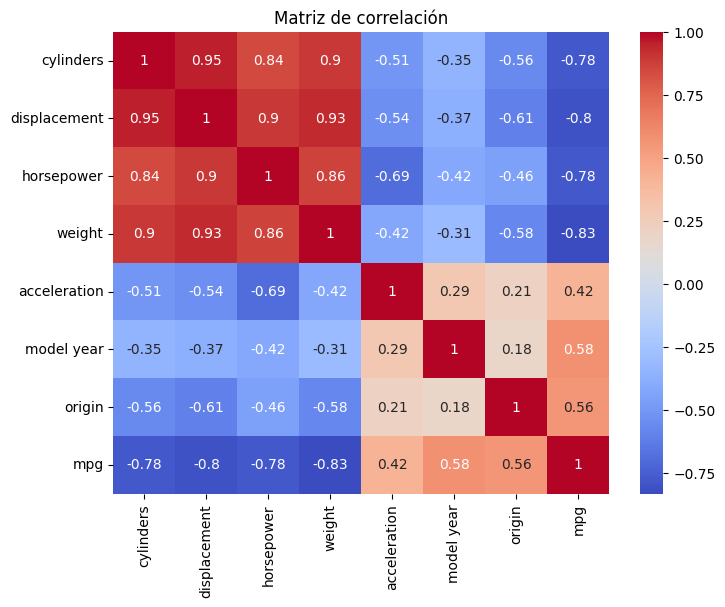

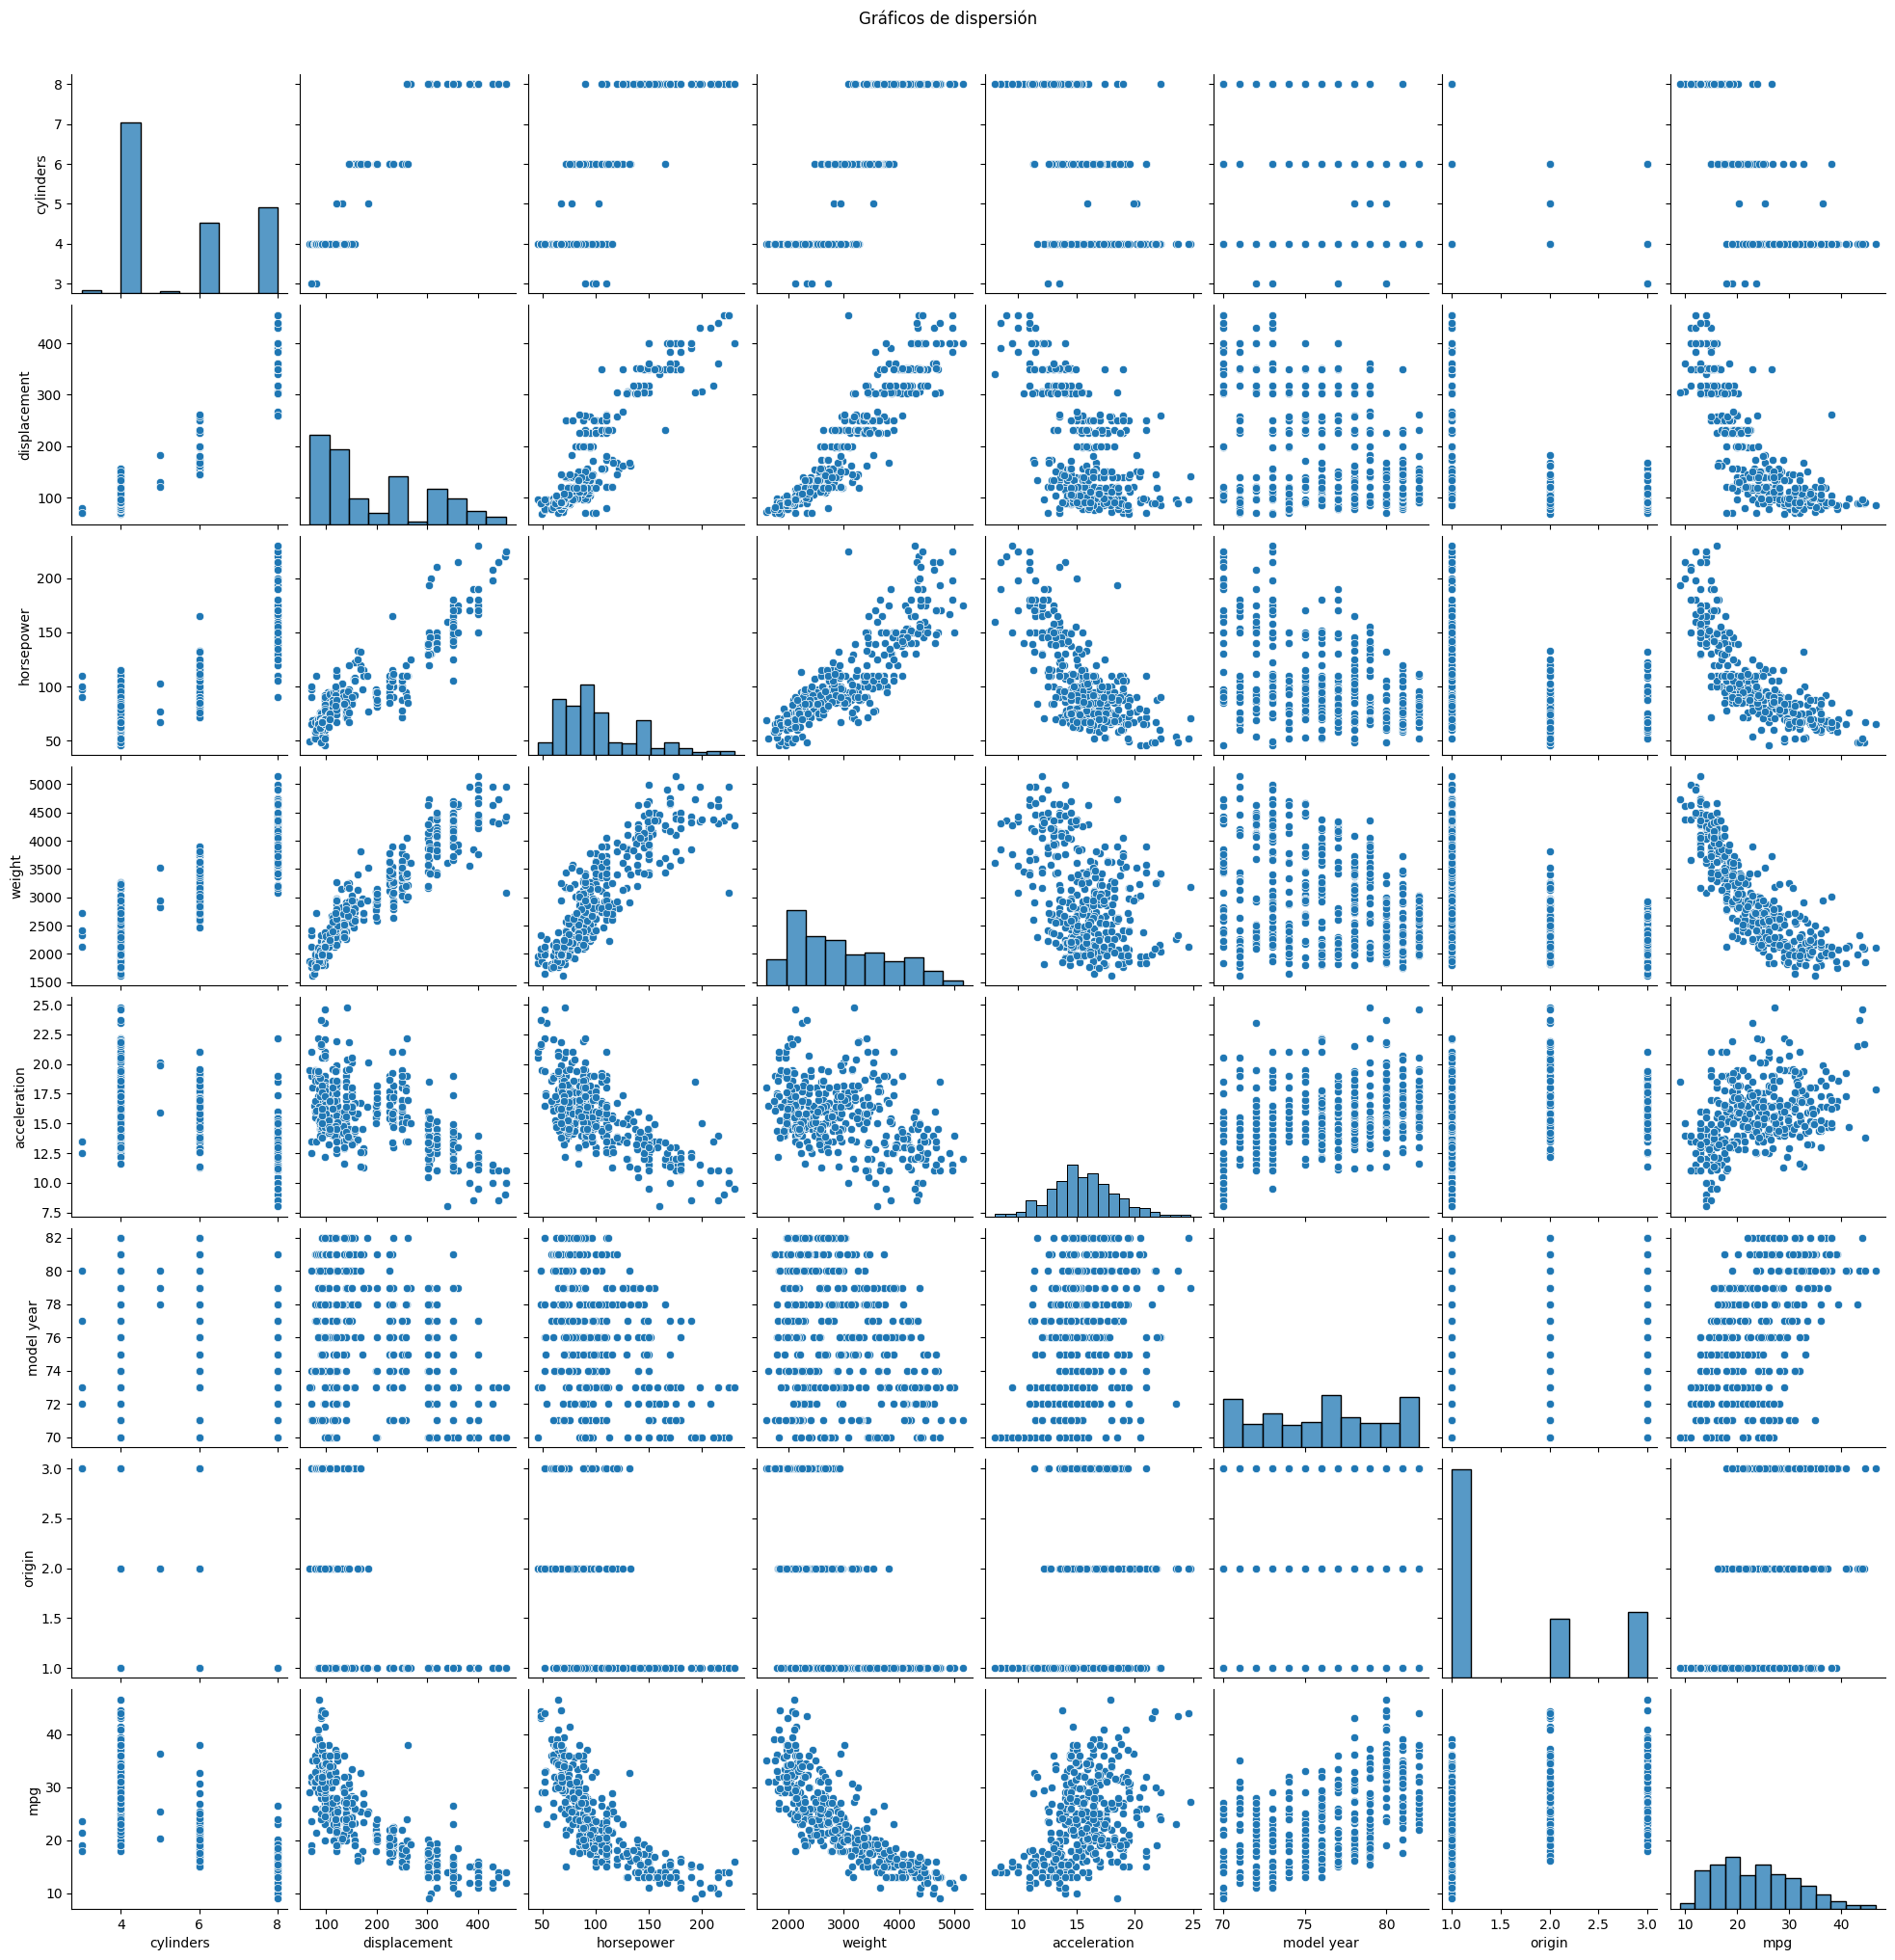

In [ ]:
print(df.info())
print(df.describe())

# Eliminar las primeras dos filas que contienen metadatos
df_clean = df.iloc[2:].copy()

# Convertir columnas relevantes a numéricas (ignorando 'car name')
cols_to_numeric = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'mpg']
for col in cols_to_numeric:
	df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(df_clean[cols_to_numeric].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

# Grafico de dispersión
sns.pairplot(df_clean[cols_to_numeric])
plt.suptitle('Gráficos de dispersión', y=1.02)
plt.show()

## 3. Modelo regresivo multivariado
Ajustamos un modelo de regresión lineal múltiple con todas las variables independientes.

In [ ]:
# Definir variables independientes y dependiente usando el dataframe limpio
X = df_clean.drop(['mpg', 'car name'], axis=1)
y = df_clean['mpg']

# Eliminar filas con NaN (por si acaso hay valores faltantes en X o y)
df_model = pd.concat([X, y], axis=1).dropna()
X = df_model.drop('mpg', axis=1)
y = df_model['mpg']

# Ajustar modelo multivariado
modelo = LinearRegression().fit(X, y)
print('Coeficientes:', modelo.coef_)
print('Intercepto:', modelo.intercept_)
print('Variables:', X.columns.tolist())

Coeficientes: [-0.49337632  0.01989564 -0.01695114 -0.00647404  0.08057584  0.75077268
  1.4261405 ]
Intercepto: -17.218434622017586
Variables: ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']


## 4. Selección de variables
Procedimiento para identificar las variables más relevantes (usando OLS y p-values).

In [ ]:
# Modelo OLS para ver significancia de variables
X_const = add_constant(X)
modelo_ols = OLS(y, X_const).fit()
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:              jue., 27 nov. 2025   Prob (F-statistic):          2.04e-139
Time:                        09:05:12   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.2184      4.644     -3.707   

## 5. Métricas de error y coeficiente de determinación
Calculamos MAE, MSE, RMSE y $R^2$ para el modelo multivariado.

In [ ]:
y_pred = modelo.predict(X)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
print(f'MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}')

MAE: 2.50, MSE: 10.85, RMSE: 3.29, R2: 0.821


## 6. Análisis de residuales
Graficamos los residuales para verificar supuestos del modelo.

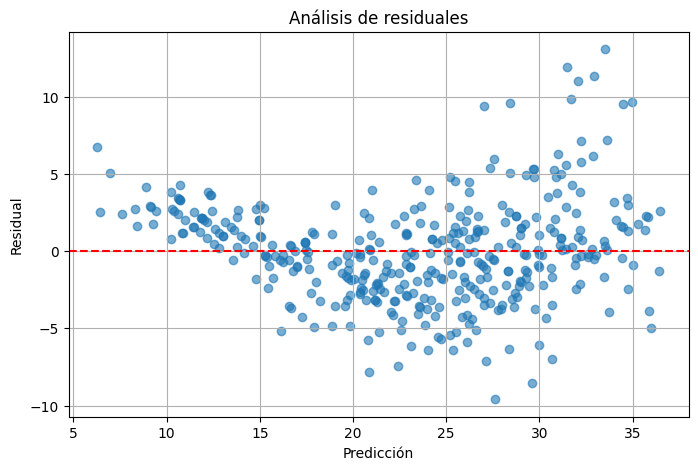

In [ ]:
residuales = y - y_pred
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuales, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicción')
plt.ylabel('Residual')
plt.title('Análisis de residuales')
plt.grid(True)
plt.show()

## 7. Interpretación y comparación de modelos
Identificamos el factor de mayor incidencia y comparamos con el modelo simple.

In [ ]:
# Comparar con modelo simple (ejemplo usando solo 'weight')
X_simple = X[['weight']] if 'weight' in X.columns else X.iloc[:, [0]]
modelo_simple = LinearRegression().fit(X_simple, y)
y_pred_simple = modelo_simple.predict(X_simple)
r2_simple = r2_score(y, y_pred_simple)
print(f'R2 modelo simple: {r2_simple:.3f}')
print(f'R2 modelo multivariado: {r2:.3f}')
print(f'MAE modelo simple: {mean_absolute_error(y, y_pred_simple):.2f}, MAE modelo multivariado: {mae:.2f}')
print(f'MSE modelo simple: {mean_squared_error(y, y_pred_simple):.2f}, MSE modelo multivariado: {mse:.2f}')

R2 modelo simple: 0.693
R2 modelo multivariado: 0.821
MAE modelo simple: 3.28, MAE modelo multivariado: 2.50
MSE modelo simple: 18.68, MSE modelo multivariado: 10.85


## 8. Conclusión
- El factor con mayor incidencia se identifica por el coeficiente más alto y el p-value más bajo en el modelo OLS.
- El modelo multivariado suele ser mejor que el simple si el $R^2$ y las métricas de error mejoran.
- Justifica tu respuesta con los resultados obtenidos.